# Train and Optimize a TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training and optimizing a neural network using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers.

Adapted from the [hello_world](https://github.com/tensorflow/tensorflow/tree/e0b19f6ef223af40e2e6d1d21b8464c1b2ebee8f/tensorflow/lite/micro/examples/hello_world/train) example for [TensorFlow Lite for MicroControllers](https://ai.google.dev/edge/lite), we will train a network to model data generated by a sine function. This will produce a model that can take a value x and predict its sine, y.

The focus of this notebook isn't on the complexity of the model, as it's a simple one that doesn't require much optimization. Instead, the main goal is to demonstrate the process of training a model and the tools available to optimize it.

## Configure Defaults

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
  os.makedirs(MODELS_DIR)
MODEL_TFLITE = MODELS_DIR + 'sine_model.tflite'
MODEL_PRUNED_TFLITE = MODELS_DIR + 'sine_model_pruned.tflite'
MODEL_CLUSTERED_TFLITE = MODELS_DIR + 'sine_model_clustered.tflite'
MODEL_QUANT_TFLITE = MODELS_DIR + 'sine_model_quant.tflite'
MODEL_QUANT_PRUNED_TFLITE = MODELS_DIR + 'sine_model_quant_pruned.tflite'
MODEL_QUANT_CLUSTERED_TFLITE = MODELS_DIR + 'sine_model_quant_clustered.tflite'

## Setup Environment

Install Dependencies

In [ ]:
import tempfile
try:
    import tensorflow as tf
    # Notebook done using Tensorflow v2.17.
    if tf.__version__ != '2.17.0':
        %pip install -q tensorflow==2.17.0
        import tensorflow as tf
except ImportError:
    # If the import fails, install the package
    %pip install -q tensorflow
    import tensorflow as tf

try:
    import tf_keras as keras # Importing keras this way is important for using pruning later
except ImportError:
    %pip install tf_keras
    import tf_keras as keras



2024-08-10 05:20:28.966669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 05:20:30.050352: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 05:20:30.362805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 05:20:30.995345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 05:20:31.153723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 05:20:32.198451: I tensorflow/core/platform/cpu_feature_gu

Import Dependencies

In [ ]:
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
# Numpy is a math library
import numpy as np

Set Seed for Repeatable Results

In [ ]:
# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results.
keras.utils.set_random_seed(100)
tf.config.experimental.enable_op_determinism()

## Dataset

### 1. Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph.

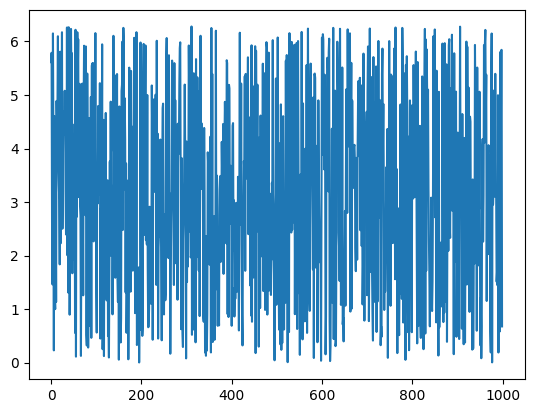

In [ ]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)
plt.plot(x_values)
plt.show()

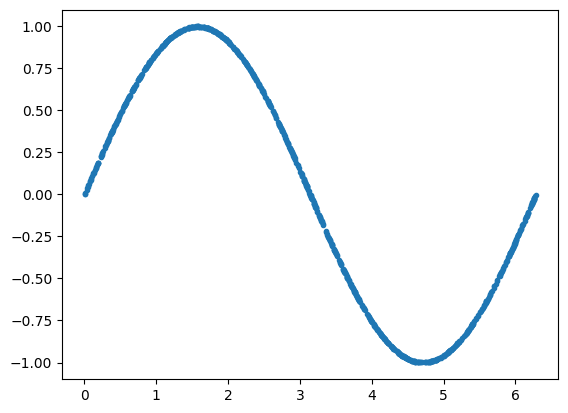

In [ ]:
# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data as dots
plt.plot(x_values, y_values, '.')
plt.show()

### 2. Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

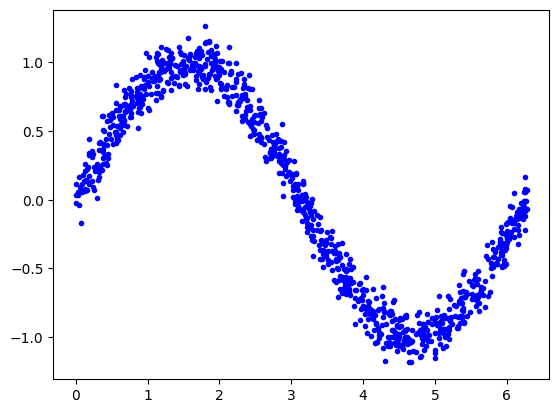

In [ ]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20%

The following code will split our data and then plots each set as a different color:


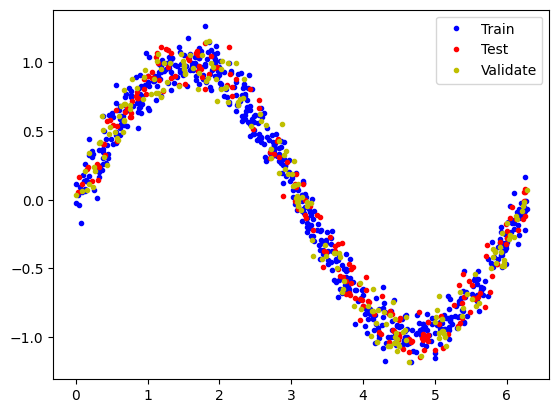

In [ ]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Training

### 1. Design the Model
We're going to build a simple neural network model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define three layers. The first layer takes a single input (our `x` value) and runs it through 16 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is also composed of 16 neurons. Finally, the result of this layer will be the input of the last layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

In [ ]:
def setup_model():
  model = keras.Sequential()

  # First layer takes a scalar input and feeds it through 16 "neurons". The
  # neurons decide whether to activate based on the 'tanh' activation function.
  model.add(keras.layers.Dense(16, activation='tanh', input_shape=(1,)))

  # The new second layer may help the network learn more complex representations
  model.add(keras.layers.Dense(16, activation='tanh'))

  # Final layer is a single neuron, since we want to output a single value
  model.add(keras.layers.Dense(1))
  return model

model = setup_model()
# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 500 _epochs_, with 16 pieces of data in each _batch_. We also pass in some data for _validation_. Training can take a while to complete, that's why we're using EarlyStopping.

An EarlyStopping callback is defined to monitor the validation loss (val_loss). Training will stop if the validation loss does not improve for 10 consecutive epochs (patience=10). The restore_best_weights=True parameter ensures the model weights are reverted to the best-performing epoch.



In [ ]:
from tf_keras.callbacks import EarlyStopping

# Set up early stopping to monitor validation loss and stop training if it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
              x_train, y_train,
              validation_data=(x_validate, y_validate),
              epochs=500,
              batch_size=32,
              callbacks=[early_stopping],
              verbose=1
          )

# save the model weights for later
_, pretrained_weights = tempfile.mkstemp('.keras')
model.save(pretrained_weights)

Epoch 1/500
19/19 [==============================] - 1s 9ms/step - loss: 0.6360 - mae: 0.7010 - val_loss: 0.4891 - val_mae: 0.6085
Epoch 2/500
19/19 [==============================] - 0s 2ms/step - loss: 0.4223 - mae: 0.5633 - val_loss: 0.3508 - val_mae: 0.5109
Epoch 3/500
19/19 [==============================] - 0s 3ms/step - loss: 0.3056 - mae: 0.4825 - val_loss: 0.2617 - val_mae: 0.4389
Epoch 4/500
19/19 [==============================] - 0s 3ms/step - loss: 0.2343 - mae: 0.4272 - val_loss: 0.2061 - val_mae: 0.3959
Epoch 5/500
19/19 [==============================] - 0s 2ms/step - loss: 0.1910 - mae: 0.3876 - val_loss: 0.1782 - val_mae: 0.3679
Epoch 6/500
19/19 [==============================] - 0s 2ms/step - loss: 0.1697 - mae: 0.3616 - val_loss: 0.1647 - val_mae: 0.3533
Epoch 7/500
19/19 [==============================] - 0s 2ms/step - loss: 0.1591 - mae: 0.3486 - val_loss: 0.1587 - val_mae: 0.3437
Epoch 8/500
19/19 [==============================] - 0s 2ms/step - loss: 0.1534 - m

### 3. Plot Metrics

**1. Mean Squared Error**

During training, the model's performance is constantly being measured against both our training data and the validation data that we set aside earlier. Training produces a log of data that tells us how the model's performance changed over the course of the training process.

The following cells will display some of that data in a graphical form:

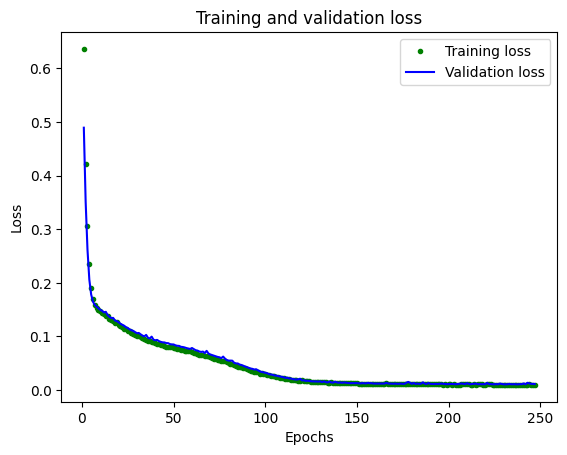

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions

To make the flatter part of the graph more readable, let's skip the first 100 epochs:

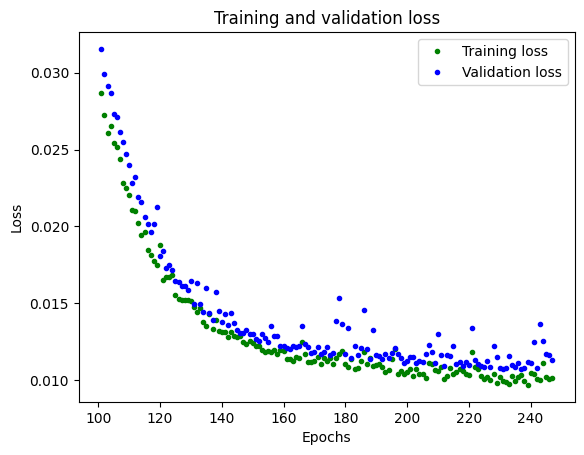

In [ ]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot, we can see that loss continues to reduce until it stalbilizes and triggers the end of the training.

We can also see that the lowest loss value is around 0.01. This means that our network's predictions are off by an average of ~1%.

**2. Mean Absolute Error**

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the _mean absolute error_, which is another way of measuring how far the network's predictions are from the actual numbers:

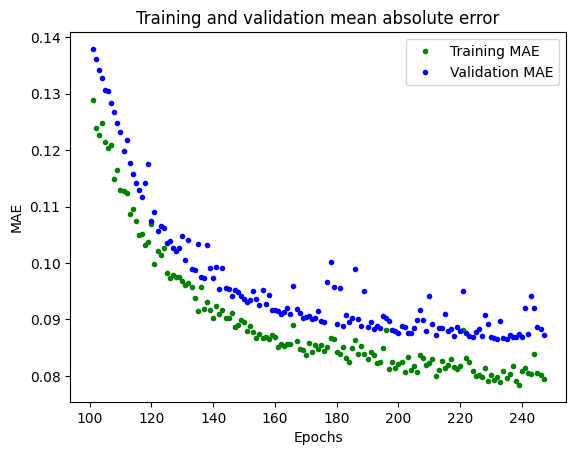

In [ ]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of _mean absolute error_ show that the training and validation curve converge, which means that the model is learning correctly. It shows that the network is able to make effective predictions about new data.

**3. Actual vs Predicted Outputs**

To get more insight into what is happening, we can plot our network's predictions for the training data against the expected values:

7/7 [==============================] - 0s 1ms/step


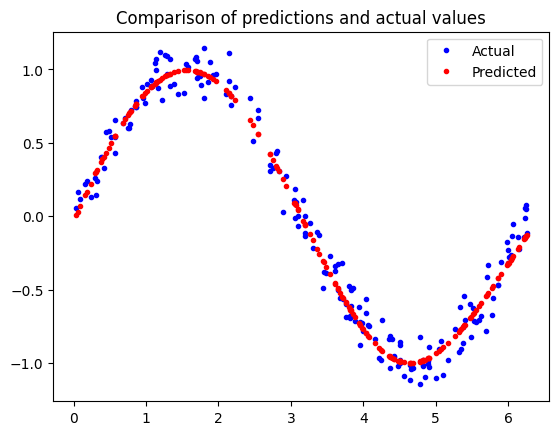

In [ ]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

The results are quite good. The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

## Generate a TensorFlow Lite Model

### 1. Optimize our model
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

But first, since this model is going to be deployed on a microcontroller, we want it to be as tiny and efficient as possible. We are going to try and compare different [optimizations techniques](https://www.tensorflow.org/lite/performance/model_optimization)

In [ ]:
# Necessary libraries for optimization
try:
    import tensorflow_model_optimization as tfmot
except ImportError:
    # If the import fails, install the package
    %pip install tensorflow_model_optimization
    import tensorflow_model_optimization as tfmot

#### Pruning
The first technique is called [Pruning](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras). The goal is to reduce the number of parameters in the model by removing less important weights, leading to a sparser model.
  * How it works:
      * Pruning removes weights that have little impact on the model's output.
      * This can be done in various ways, such as removing weights below a certain threshold.
      * The resulting model has many zero weights, which can be stored more efficiently and processed faster.
  * Process:
    * Define a pruning schedule which is how sparsity (the fraction of weights that are zero) changes over time during training. For example, polynomial decay is a type of pruning schedule that gradually increases the sparsity of the model's weights over time according to a polynomial function
    * Apply the pruning operation during training.
    * Fine-tune the model to recover any accuracy lost during pruning.
    * Strip the pruning operations to finalize the model for deployment.

In [ ]:
def print_model_weights_sparsity(model):
    print("\n")
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

# Calculate the number of steps
batch_size = 64
epochs = 10
steps_per_epoch = np.ceil(len(x_train) / batch_size).astype(np.int32)
end_step = steps_per_epoch * epochs

# Define pruning parameters using PolynomialDecay
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.2,
        begin_step=0,
        end_step=end_step
    )
}

# We use the pretrained model from earlier
pruning_model = setup_model()
pruning_model.load_weights(pretrained_weights)
print_model_weights_sparsity(pruning_model)

# Apply pruning
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruned_model = prune_low_magnitude(pruning_model, **pruning_params)
pruned_model.summary()



dense_3/kernel:0: 0.00% sparsity  (0/16)
dense_4/kernel:0: 0.00% sparsity  (0/256)
dense_5/kernel:0: 0.00% sparsity  (0/16)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense_  (None, 16)                50        
 3 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 16)                530       
 4 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 1)                 35        
 5 (PruneLowMagnitude)                                           
                                                                 
Total params: 615 (2.41 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 294 (1.16 KB)
______________________________

Now that we defined the parameters of the pruning, we can fine-tune our model to add sparsity

In [ ]:
import tempfile
logdir = tempfile.mkdtemp()
# The callbacks allow monitoring of the fine-tuning
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print_model_weights_sparsity(pruned_model))
]

# Use smaller learning rate for fine-tuning
opt = keras.optimizers.Adam(learning_rate=1e-6)

# Fine tune the model
pruned_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
history_pruning = pruned_model.fit(x_train, y_train, epochs=epochs,
                                   validation_data=(x_validate, y_validate),
                                   callbacks=callbacks)

Epoch 1/10
 1/19 [>.............................] - ETA: 33s - loss: 0.0073 - mae: 0.0677WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.0039s). Check your callbacks.


dense_3/kernel:0: 0.00% sparsity  (0/16)
dense_4/kernel:0: 0.00% sparsity  (0/256)
dense_5/kernel:0: 0.00% sparsity  (0/16)
19/19 [==============================] - 2s 12ms/step - loss: 0.0097 - mae: 0.0785 - val_loss: 0.0107 - val_mae: 0.0868
Epoch 2/10
 1/19 [>.............................] - ETA: 0s - loss: 0.0050 - mae: 0.0569

dense_3/kernel:0: 0.00% sparsity  (0/16)
dense_4/kernel:0: 0.00% sparsity  (0/256)
dense_5/kernel:0: 0.00% sparsity  (0/16)
19/19 [==============================] - 0s 4ms/step - loss: 0.0097 - mae: 0.0785 - val_loss: 0.0107 - val_mae: 0.0868
Epoch 3/10
 1/19 [>.............................] - ETA: 0s - loss: 0.0091 - mae: 0.0718

dense_3/kernel:0: 0.00% sparsity  (0/16)
dense_4/kernel:0: 0.00% spa

In [ ]:
# Remove every tf.Variable that pruning only needs during training
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
# Check that the sparsity is 20%
print_model_weights_sparsity(stripped_pruned_model)



dense_3/kernel:0: 18.75% sparsity  (3/16)
dense_4/kernel:0: 19.92% sparsity  (51/256)
dense_5/kernel:0: 18.75% sparsity  (3/16)


As expected, the pruning has added ~20% sparsity to our model. It means that around 20% of our weights have a value of 0. Increasing the percentage of sparsity for a small model like this would degrade its performance too much.

#### Clustering

The second technique is called [Clustering](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example). The goal here is to reduce the number of unique weight values in the model by clustering weights around a smaller set of values.
  * How it works:
      * Clustering groups the model's weights into a fixed number of clusters.
      * All weights in a cluster are shared, reducing the number of unique weight values.
      * This can significantly reduce the model size when weights are compressed.
  * Process:
      * Define clustering parameters (e.g., number of clusters).
      * Apply the clustering operation during training.
      * Fine-tune the model to adjust to the new weight values.
      * Strip the clustering operations to finalize the model for deployment.

In [ ]:
def print_model_weights_clustering(model, label):
    print(f"Model: {label}")
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )
    print("\n")

clustering_params = {
    'number_of_clusters': 8,
    'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS
}

# We use the pretrained model from earlier
clustering_model = setup_model()
clustering_model.load_weights(pretrained_weights)
print_model_weights_clustering(clustering_model, "Original Model")

# Apply clustering
cluster_weights = tfmot.clustering.keras.cluster_weights
clustered_model = cluster_weights(clustering_model, **clustering_params)
clustered_model.summary()

Model: Original Model
dense_6/dense_6/kernel:0: 16 clusters 
dense_7/dense_7/kernel:0: 256 clusters 
dense_8/dense_8/kernel:0: 16 clusters 


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_dense_6 (ClusterWe  (None, 16)                56        
 ights)                                                          
                                                                 
 cluster_dense_7 (ClusterWe  (None, 16)                536       
 ights)                                                          
                                                                 
 cluster_dense_8 (ClusterWe  (None, 1)                 41        
 ights)                                                          
                                                                 
Total params: 633 (3.60 KB)
Trainable params: 345 (1.35 KB)
Non-trainable params: 288 (2.25 KB)
______________

In [ ]:
# Use smaller learning rate for fine-tuning
opt = keras.optimizers.Adam(learning_rate=1e-6)

# Fine-tune the model
clustered_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
history_clustering = clustered_model.fit(x_train, y_train, epochs=1,
                                        validation_data=(x_validate, y_validate))


19/19 [==============================] - 1s 11ms/step - loss: 0.0826 - mae: 0.2200 - val_loss: 0.0875 - val_mae: 0.2292


In [ ]:
# Remove every tf.Variable that clustering only needs during training
stripped_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)
# Verify that the clustering is done
print_model_weights_clustering(stripped_clustered_model, "Clustered Model")

Model: Clustered Model
dense_6/kernel:0: 8 clusters 
dense_7/kernel:0: 8 clusters 
dense_8/kernel:0: 8 clusters 




This output confirms that for each layer, the weights have been regrouped into 8 clusters

#### Quantization

The last technique is [Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It aims to reduce the precision of the model's weights and activations, typically from floating-point to integer, to reduce model size and improve inference speed.In our case, we are doing an [integer-only quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant#convert_using_integer-only_quantization). It means that we're using 8-bit integers for operations and also for input/output.
* How it works:
    * Quantization converts weights and activations to a lower precision format (e.g., 8-bit integers).
    * This reduces the amount of memory required to store the model and speeds up computations.
* Process:
    * Define quantization parameters and optimization settings.
    * Provide a representative dataset to guide the quantization process.
    * Convert the model to the TensorFlow Lite format with quantization settings.

Since we're choosing post-training quantization using TFLite, the operation is performed at the same time as the conversion of the model to TensorFlow Lite, that's why we use it after applying the other optimization techniques.

In [ ]:
# Create a representative dataset for quantization
def representative_dataset():
  for i in range(500):
    yield[x_train[i].astype(np.float32)]

# Convert to a Tensorflow Lite model
def convert_to_tflite(model, quantize=False):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  if quantize:
    # Set the optimization flag.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Provide a representative dataset to ensure we quantize correctly.
    converter.representative_dataset = representative_dataset
    # Enforce full-int8 quantization for operations
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # Set the input and output tensors to uint8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
  return converter.convert()

We can now use these functions to convert and quantize our models

In [ ]:
# Convert the models to tflite
model_tflite = convert_to_tflite(model, quantize=False)
model_pruned_tflite = convert_to_tflite(stripped_pruned_model, quantize=False)
model_clustered_tflite = convert_to_tflite(stripped_clustered_model, quantize=False)
model_quant_tflite = convert_to_tflite(model, quantize=True)
model_quant_pruned_tflite = convert_to_tflite(stripped_pruned_model, quantize=True)
model_quant_clustered_tflite = convert_to_tflite(stripped_clustered_model, quantize=True)

# Save the models to disk
open(MODEL_TFLITE, "wb").write(model_tflite)
open(MODEL_PRUNED_TFLITE, "wb").write(model_pruned_tflite)
open(MODEL_CLUSTERED_TFLITE, "wb").write(model_clustered_tflite)
open(MODEL_QUANT_TFLITE, "wb").write(model_quant_tflite)
open(MODEL_QUANT_PRUNED_TFLITE, "wb").write(model_quant_pruned_tflite)
open(MODEL_QUANT_CLUSTERED_TFLITE, "wb").write(model_quant_clustered_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp3ix3ttth/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ix3ttth/assets
W0000 00:00:1723267936.055251   30139 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723267936.055285   30139 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-10 05:32:16.055456: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3ix3ttth
2024-08-10 05:32:16.056110: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-10 05:32:16.056127: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp3ix3ttth
2024-08-10 05:32:16.060653: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-10 05:32:16.088982: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp3ix3ttth
2024-08-10 05:32:16.100067: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 44614 

INFO:tensorflow:Assets written to: /tmp/tmpxwl4vz41/assets


INFO:tensorflow:Assets written to: /tmp/tmpxwl4vz41/assets
W0000 00:00:1723267936.544517   30139 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723267936.544547   30139 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-10 05:32:16.544787: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxwl4vz41
2024-08-10 05:32:16.545713: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-10 05:32:16.545733: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpxwl4vz41
2024-08-10 05:32:16.550154: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-10 05:32:16.568463: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpxwl4vz41
2024-08-10 05:32:16.575517: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 30734 

INFO:tensorflow:Assets written to: /tmp/tmp7nhpgr95/assets


INFO:tensorflow:Assets written to: /tmp/tmp7nhpgr95/assets
W0000 00:00:1723267936.976845   30139 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723267936.976872   30139 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-10 05:32:16.977034: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7nhpgr95
2024-08-10 05:32:16.977638: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-10 05:32:16.977654: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7nhpgr95
2024-08-10 05:32:16.981424: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-10 05:32:16.993677: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp7nhpgr95
2024-08-10 05:32:16.998427: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 21396 

INFO:tensorflow:Assets written to: /tmp/tmp8zyakd12/assets


INFO:tensorflow:Assets written to: /tmp/tmp8zyakd12/assets
/usr/local/python/3.10.13/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1723267937.558739   30139 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723267937.558761   30139 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-10 05:32:17.558924: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8zyakd12
2024-08-10 05:32:17.559763: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-10 05:32:17.559780: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8zyakd12
2024-08-10 05:32:17.565120: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-10 05:32:17.593223: I tensorflow/cc/saved_model/loader.cc:220] Run

INFO:tensorflow:Assets written to: /tmp/tmpupr_yfdj/assets


INFO:tensorflow:Assets written to: /tmp/tmpupr_yfdj/assets
/usr/local/python/3.10.13/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1723267937.987113   30139 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723267937.987136   30139 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-10 05:32:17.987301: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpupr_yfdj
2024-08-10 05:32:17.987797: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-10 05:32:17.987813: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpupr_yfdj
2024-08-10 05:32:17.990204: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-10 05:32:18.002779: I tensorflow/cc/saved_model/loader.cc:220] Run

INFO:tensorflow:Assets written to: /tmp/tmpijov05y4/assets


INFO:tensorflow:Assets written to: /tmp/tmpijov05y4/assets
/usr/local/python/3.10.13/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1723267938.375000   30139 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723267938.375022   30139 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-10 05:32:18.375194: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpijov05y4
2024-08-10 05:32:18.375705: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-10 05:32:18.375720: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpijov05y4
2024-08-10 05:32:18.378124: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-10 05:32:18.390299: I tensorflow/cc/saved_model/loader.cc:220] Run

3672

### 2. Compare Model Sizes

In order to see the compression benefits of pruning and clustering, both `strip_pruning`/`strip_clustering` and applying a standard compression algorithm are necessary

In [ ]:
def get_gzipped_tflite_size(tflite_file_path):
    # Returns size of gzipped TFLite model, in bytes.
    import gzip
    import tempfile

    # Read the TFLite file
    with open(tflite_file_path, 'rb') as f:
        tflite_model = f.read()

    # Create a temporary file for the gzipped version
    _, gzipped_file = tempfile.mkstemp('.tflite.gz')

    # Gzip the TFLite model
    with gzip.open(gzipped_file, 'wb') as f:
        f.write(tflite_model)

    # Get the size of the gzipped file
    gzipped_size = os.path.getsize(gzipped_file)

    # Clean up the temporary file
    os.remove(gzipped_file)

    return gzipped_size

import os
model_size = get_gzipped_tflite_size(MODEL_TFLITE)
pruned_model_size = get_gzipped_tflite_size(MODEL_PRUNED_TFLITE)
clustered_model_size = get_gzipped_tflite_size(MODEL_CLUSTERED_TFLITE)
model_quant_size = get_gzipped_tflite_size(MODEL_QUANT_TFLITE)
pruned_model_quant_size = get_gzipped_tflite_size(MODEL_QUANT_PRUNED_TFLITE)
clustered_model_quant_size = get_gzipped_tflite_size(MODEL_QUANT_CLUSTERED_TFLITE)

print("Model size:", model_size, "bytes")
print("Pruned model size:", pruned_model_size, "bytes")
print("Clustered model size:", clustered_model_size, "bytes")
print("Quantized model size:", model_quant_size, "bytes")
print("Pruned and quantized model size:", pruned_model_quant_size, "bytes")
print("Clustered and quantized model size:", clustered_model_quant_size, "bytes")

Model size: 2192 bytes
Pruned model size: 2030 bytes
Clustered model size: 1376 bytes
Quantized model size: 1712 bytes
Pruned and quantized model size: 1672 bytes
Clustered and quantized model size: 1516 bytes


At our level, the different optimization techniques don't have much impact on the size. More complex models have many more weights, meaning the space saving from the optimization will be much higher, approaching 4x for most sophisticated models.

Regardless, our optimized models will take less time to execute than the original version, which is important on a tiny microcontroller.

### 3. Test the Models

To show the changes in accuracy after pruning and clustering, we can load our TFLite models and run inferences to compare with our original model

input type for original model:  <class 'numpy.float32'>
output type for original model:  <class 'numpy.float32'>
input type for quantized model:  <class 'numpy.int8'>
output type for quantized model:  <class 'numpy.int8'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


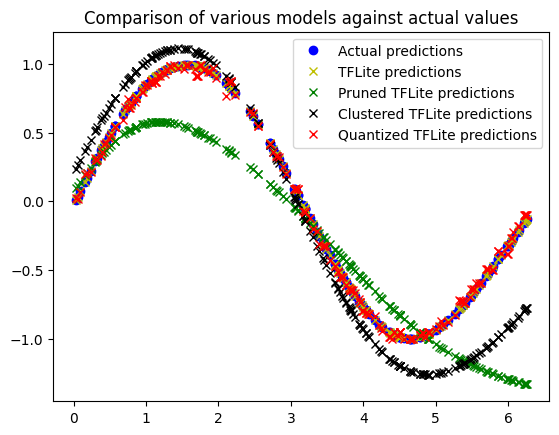

In [ ]:
# Load the TFLite models
lite_model = tf.lite.Interpreter(model_path=MODEL_TFLITE)
lite_model.allocate_tensors()

lite_model_pruned = tf.lite.Interpreter(model_path=MODEL_PRUNED_TFLITE)
lite_model_pruned.allocate_tensors()

lite_model_clustered = tf.lite.Interpreter(model_path=MODEL_CLUSTERED_TFLITE)
lite_model_clustered.allocate_tensors()

lite_model_quant = tf.lite.Interpreter(model_path=MODEL_QUANT_TFLITE)
lite_model_quant.allocate_tensors()

# Get input and output tensors details for the models
lite_model_input_details = lite_model.get_input_details()[0]
lite_model_output_details = lite_model.get_output_details()[0]
print("input type for original model: ", lite_model_input_details['dtype'])
print("output type for original model: ", lite_model_output_details['dtype'])

lite_model_pruned_input_details = lite_model_pruned.get_input_details()[0]
lite_model_pruned_output_details = lite_model_pruned.get_output_details()[0]

lite_model_clustered_input_details = lite_model_clustered.get_input_details()[0]
lite_model_clustered_output_details = lite_model_clustered.get_output_details()[0]

lite_model_quant_input_details = lite_model_quant.get_input_details()[0]
lite_model_quant_output_details = lite_model_quant.get_output_details()[0]
print("input type for quantized model: ", lite_model_quant_input_details['dtype'])
print("output type for quantized model: ", lite_model_quant_output_details['dtype'])

# Get quantization parameters
input_scale, input_zero_point = lite_model_quant_input_details['quantization']
output_scale, output_zero_point = lite_model_quant_output_details['quantization']

# Function to run inference on the unquantized model
def run_inference(interpreter, input_details, output_details, x_test):
    predictions = []
    for x in x_test:
        input_data = np.array([[x]], dtype=np.float32)
        interpreter.set_tensor(input_details['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details['index'])
        predictions.append(output_data[0][0])
    return np.array(predictions)

# Function to run inference on the quantized model
def run_inference_quant(interpreter, input_details, output_details, x_test, input_scale, input_zero_point, output_scale, output_zero_point):
    predictions = []
    for x in x_test:
        # Quantize input data
        input_data = np.array([[x]], dtype=np.float32)
        # Convert the float32 to int8
        input_data_int8 = np.round(input_data / input_scale + input_zero_point).astype(np.int8)

        interpreter.set_tensor(input_details['index'], input_data_int8)
        interpreter.invoke()

        # Dequantize output data
        output_data_int8 = interpreter.get_tensor(output_details['index'])
        output_data = (output_data_int8 - output_zero_point) * output_scale
        predictions.append(output_data[0][0])
    return np.array(predictions)

# Run inference on both models
predictions_tflite = run_inference(lite_model, lite_model_input_details, lite_model_output_details, x_test)
predictions_pruned = run_inference(lite_model_pruned, lite_model_pruned_input_details, lite_model_pruned_output_details, x_test)
predictions_clustered = run_inference(lite_model_clustered, lite_model_clustered_input_details, lite_model_clustered_output_details, x_test)
predictions_quant = run_inference_quant(lite_model_quant, lite_model_quant_input_details, lite_model_quant_output_details, x_test, input_scale, input_zero_point, output_scale, output_zero_point)

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, predictions, 'bo', label='Actual predictions')
plt.plot(x_test, predictions_tflite, 'yx', label='TFLite predictions')
plt.plot(x_test, predictions_pruned, 'gx', label='Pruned TFLite predictions')
plt.plot(x_test, predictions_clustered, 'kx', label='Clustered TFLite predictions')
plt.plot(x_test, predictions_quant, 'rx', label='Quantized TFLite predictions')
plt.legend()
plt.show()

We can see from the graph that the predictions for the converted model and the quantized model overlap. It means that quantization doesn't have an impact on accuracy here. However, for clustering and pruning, we can see a bigger loss in accuracy, even if the predictions follow the course of a sine wave. This may be due to the fact that our model is too small and suffer too much from the clusters and sparsity introduced.

We can also verify those observations by calculating the MSE and MAE of our models:

In [ ]:
# Calculate and print the MSE and MAE
mse_tflite = np.mean((np.sin(x_test) - predictions_tflite) ** 2)
mae_tflite = np.mean(np.abs(np.sin(x_test) - predictions_tflite))

mse_pruned = np.mean((np.sin(x_test) - predictions_pruned) ** 2)
mae_pruned = np.mean(np.abs(np.sin(x_test) - predictions_pruned))

mse_clustered = np.mean((np.sin(x_test) - predictions_clustered) ** 2)
mae_clustered = np.mean(np.abs(np.sin(x_test) - predictions_clustered))

mse_quant = np.mean((np.sin(x_test) - predictions_quant) ** 2)
mae_quant = np.mean(np.abs(np.sin(x_test) - predictions_quant))

print("Unquantized Model:")
print("MSE:", mse_tflite)
print("MAE:", mse_tflite)

print("\nPruned Model:")
print("MSE:", mse_pruned)
print("MAE:", mae_pruned)

print("\nClustered Model:")
print("MSE:", mse_clustered)
print("MAE:", mae_clustered)

print("\nQuantized Model:")
print("MSE:", mse_quant)
print("MAE:", mae_quant)

Unquantized Model:
MSE: 0.0006077849
MAE: 0.0006077849

Pruned Model:
MSE: 0.19373055
MAE: 0.31752485

Clustered Model:
MSE: 0.086264856
MAE: 0.23276283

Quantized Model:
MSE: 0.0012470504485593737
MAE: 0.027644506003707648


These results confirm what we saw on the graph. The quantized model has a similar performance to the original model, while the pruned and clustered models have a higher loss.

# Wrapping Up

In this notebook, we've trained a simple neural network to model a sine function, then optimized and converted it for use with TensorFlow Lite for Microcontrollers. We've also explored different optimization techniques to reduce the model size and speed up inference.

The final model can be used in a microcontroller project to predict the sine of an input value. This can be useful for a variety of applications, such as sensor data processing, gesture recognition, and more.

The techniques we've used here can be applied to more complex models and datasets, and can help create efficient and accurate models for other projects.

In the following [notebook](https://github.com/Kiboya/Machine-Learning-Notebooks/blob/012723f985c0a57d1b344c861f41c558ccdfcbc4/TensorFlow%20Lite%20For%20Microcontrollers/tflm_model_deployment_and_test.ipynb), we'll show how to deploy and test this model on a microcontroller.